In [68]:
import numpy as np
import scipy as sp
import pandas as pd
 
import matplotlib.pyplot as plt
import matplotlib as mpl
 
import math
 
from scipy import stats
from scipy.stats import norm

from sklearn import mixture
import matplotlib.pyplot
import matplotlib.mlab
from pylab import *
from scipy.optimize import leastsq
 
#from scipy.optimize import curve_fit
#from lmfit import Model

In [44]:
def DetermineBursts(group, ignore_dark): #Identifies the bright segments, ignoring dark times below the specified threshold
    bursts = []
    ignore_dark = ignore_dark+1
    burst = []
    previous_frame = -10000
    for index, row in group.iterrows():
        frame = row["frame"]
        if frame - previous_frame <= ignore_dark:
            burst.append(frame)
        else:
            bursts.append(burst)
            burst = []
            burst.append(frame)
        previous_frame = frame
    bursts.append(burst)
    return(bursts[1:]) #The first entry of bursts is always [], so it can be discarded
 
def CalculateBright_halfapprox(bursts): #Calculates the lengths of the bright times
    brights = []
    for entry in bursts:
        brights.append(entry[-1]-entry[0]+0.5)
    return(brights)
 
def CalculateDark_halfapprox(bursts): #Calculates the lengths of the dark times
    darks = []
    last = 0
    for entry in bursts:
        first = entry[0]
        difference = first-last
        last = entry[-1]
        darks.append(difference-0.5)
    return(darks[1:]) #The first entry is discarded, as it is just the time from the start of the measurement until the first bright segment
 
def CalculateDark(bursts): #Calculates the lengths of the dark times
    darks = []
    previous_first = 0
    for entry in bursts:
        first = entry[0]
        difference = first-previous_first
        previous_first = first
        darks.append(difference-1)
    return(darks[1:])
    
def LinkLocalizations(group, ignore_dark):
    bursts = DetermineBursts(group, ignore_dark)
    dark = CalculateDark(bursts)
    bright_halfapprox = CalculateBright_halfapprox(bursts)
    return(bright_halfapprox, dark, bursts)

def LinkLocalizationsOld(group, ignore_dark):
    bursts = DetermineBursts(group, ignore_dark)
    dark_halfapprox = CalculateDark_halfapprox(bursts)
    bright_halfapprox = CalculateBright_halfapprox(bursts)
    return(bright_halfapprox, dark_halfapprox, bursts)

def Import(input_path):
    fulltable = pd.read_hdf(input_path, key = 'locs')
    betterfulltable = fulltable.sort_values(by=['group', 'frame'])
    return(betterfulltable)

In [58]:
pathR1 = "/Volumes/pool-miblab4/users/reinhardt/z_raw/Resi/220125_Nup96-GFP_4c/aligned/R1_7nt_150pM_18mW_150ms_561_1_MMStack_Pos0.ome_locs_render_render_filter_aligned_apicked_ClusterD11_10_22.0.hdf5"
pathR2 = "/Volumes/pool-miblab4/users/reinhardt/z_raw/Resi/220125_Nup96-GFP_4c/aligned/R2_7nt_100pM_18mW_150ms_561_1_MMStack_Pos0.ome_locs_render_render_filter_aligned_apicked_ClusterD11_10_22.0.hdf5"
pathR3 = "/Volumes/pool-miblab4/users/reinhardt/z_raw/Resi/220125_Nup96-GFP_4c/aligned/R3_7nt_100pM_18mW_150ms_561_1_MMStack_Pos0.ome_locs_render_render_filter_aligned_apicked_ClusterD11_10_22.0.hdf5"
pathR4 = "/Volumes/pool-miblab4/users/reinhardt/z_raw/Resi/220125_Nup96-GFP_4c/aligned/R4_7nt_100pM_18mW_150ms_561_1_MMStack_Pos0.ome_locs_render_render_filter_aligned_apicked_ClusterD11_10_22.0.hdf5"

fulltable = Import(pathR1)

ignore_dark = 0

In [59]:
bright_time_table = []
dark_time_table = []
bursts_table = []
index_table = []
number_of_binding_events_per_site = []

for i in range(max(fulltable["group"])+1): 
    bright_time, dark_time, bursts = LinkLocalizations((fulltable[fulltable["group"] == (i) ]), ignore_dark)
    if bursts != []:
        bright_time_table.append(bright_time)
        dark_time_table.append(dark_time)
        bursts_table.append(bursts)
        number_of_binding_events_per_site.append(len(bursts))

In [53]:
'''
bright_time_table = []
dark_time_table = []
bursts_table = []
index_table = []
number_of_binding_events_per_site = []

for i in range(max(fulltable["group"])+1): 
    bright_time, dark_time, bursts = LinkLocalizationsOld((fulltable[fulltable["group"] == (i) ]), ignore_dark)
    if bursts != []:
        bright_time_table.append(bright_time)
        dark_time_table.append(dark_time)
        bursts_table.append(bursts)
        number_of_binding_events_per_site.append(len(bursts))
'''

[1.5, 0.5, 10.5, 3.5, 0.5, 6.5, 0.5, 8.5, 10.5, 0.5, 1.5, 4.5, 1.5, 5.5, 1.5, 0.5, 0.5, 0.5, 8.5]
[1364.5, 10.5, 80.5, 404.5, 259.5, 921.5, 149.5, 245.5, 98.5, 1689.5, 194.5, 682.5, 2.5, 286.5, 146.5, 1788.5, 1127.5, 490.5]
[1.5, 4.5, 7.5, 0.5, 4.5, 9.5, 2.5, 1.5, 3.5]
[1334.5, 2988.5, 2302.5, 1017.5, 26.5, 632.5, 1897.5, 494.5]
[2.5, 4.5, 0.5, 0.5, 0.5, 1.5, 0.5, 5.5, 6.5, 0.5, 0.5, 0.5, 0.5, 1.5, 7.5, 0.5, 0.5, 0.5, 2.5, 0.5, 1.5, 4.5, 3.5, 8.5]
[299.5, 87.5, 639.5, 369.5, 3302.5, 462.5, 481.5, 403.5, 7.5, 57.5, 33.5, 221.5, 3.5, 128.5, 55.5, 2142.5, 7.5, 2.5, 2.5, 2.5, 53.5, 106.5, 91.5]
[0.5, 21.5, 1.5, 13.5, 3.5, 0.5, 5.5, 8.5, 1.5, 2.5, 2.5, 2.5, 2.5, 6.5, 1.5, 2.5]
[69.5, 186.5, 210.5, 3014.5, 1821.5, 2092.5, 3.5, 110.5, 284.5, 2.5, 10.5, 6.5, 3.5, 1455.5, 327.5]
[0.5, 0.5, 2.5, 9.5, 5.5, 0.5, 1.5, 2.5, 6.5]
[2327.5, 638.5, 1961.5, 320.5, 596.5, 2176.5, 433.5, 2587.5]
[1.5, 1.5, 4.5, 5.5, 1.5, 3.5, 2.5, 0.5, 2.5, 0.5, 1.5, 0.5, 9.5, 2.5, 6.5, 0.5, 2.5, 6.5, 1.5, 0.5, 0.5, 0.5, 4

[0.5, 1.5, 0.5, 0.5, 1.5, 0.5, 10.5, 7.5, 4.5, 3.5, 0.5, 8.5, 17.5, 0.5, 4.5, 0.5]
[2640.5, 417.5, 160.5, 1147.5, 1369.5, 214.5, 466.5, 481.5, 2.5, 1098.5, 2249.5, 1063.5, 3.5, 62.5, 120.5]
[1.5, 0.5, 4.5, 5.5, 0.5, 1.5, 16.5, 0.5, 4.5, 0.5, 2.5, 1.5]
[1246.5, 334.5, 506.5, 240.5, 173.5, 140.5, 469.5, 811.5, 4025.5, 2218.5, 943.5]
[3.5, 3.5, 5.5, 15.5, 0.5, 3.5, 4.5, 0.5, 3.5]
[47.5, 3.5, 736.5, 2331.5, 454.5, 2449.5, 2087.5, 2060.5]
[0.5, 2.5, 2.5, 0.5, 1.5, 1.5, 2.5, 0.5, 0.5, 2.5, 4.5, 0.5, 3.5, 11.5]
[101.5, 474.5, 2.5, 979.5, 564.5, 76.5, 1453.5, 2754.5, 102.5, 779.5, 3197.5, 250.5, 357.5]
[1.5, 3.5, 0.5, 3.5, 1.5, 1.5, 7.5, 6.5, 5.5, 3.5, 1.5, 4.5, 4.5, 6.5, 5.5, 3.5]
[2148.5, 857.5, 466.5, 237.5, 506.5, 2.5, 9.5, 1936.5, 810.5, 1114.5, 2.5, 1206.5, 955.5, 696.5, 118.5]
[1.5, 5.5, 0.5, 10.5, 2.5, 1.5, 8.5, 0.5, 9.5, 1.5, 1.5, 3.5, 1.5, 1.5]
[185.5, 406.5, 730.5, 235.5, 427.5, 1508.5, 3.5, 3.5, 370.5, 17.5, 2596.5, 184.5, 2646.5]
[2.5, 2.5, 1.5, 5.5, 1.5, 5.5, 7.5, 3.5, 4.5, 0.5]


[5.5, 0.5, 24.5, 1.5, 1.5, 1.5, 10.5, 17.5, 2.5, 1.5, 2.5, 11.5, 0.5, 0.5, 0.5]
[705.5, 171.5, 2.5, 1184.5, 480.5, 400.5, 1011.5, 1094.5, 254.5, 954.5, 321.5, 1720.5, 864.5, 5.5]
[0.5, 8.5, 1.5, 18.5, 8.5, 1.5]
[796.5, 1179.5, 1732.5, 3811.5, 1346.5]
[3.5, 3.5, 1.5, 0.5, 0.5, 3.5, 1.5, 16.5, 1.5, 1.5, 0.5, 2.5, 7.5, 6.5, 0.5, 2.5, 1.5, 2.5, 1.5]
[1480.5, 2.5, 3.5, 959.5, 524.5, 38.5, 2.5, 861.5, 272.5, 1214.5, 479.5, 3995.5, 12.5, 543.5, 4.5, 3.5, 2.5, 230.5]
[4.5, 2.5, 4.5, 4.5, 0.5, 6.5]
[153.5, 2.5, 2244.5, 3256.5, 5472.5]
[3.5, 1.5, 0.5, 0.5, 6.5, 1.5, 3.5, 0.5, 4.5, 1.5, 5.5, 2.5, 6.5, 2.5, 1.5, 3.5]
[4.5, 1402.5, 930.5, 3.5, 1030.5, 6.5, 5.5, 1852.5, 1737.5, 32.5, 1194.5, 203.5, 2.5, 3037.5, 464.5]
[12.5, 0.5, 0.5, 1.5, 1.5, 1.5, 11.5, 3.5, 0.5, 5.5]
[609.5, 2.5, 4517.5, 1039.5, 1420.5, 461.5, 1462.5, 314.5, 966.5]
[3.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 3.5, 0.5, 0.5, 3.5, 0.5, 10.5, 12.5, 1.5, 9.5, 1.5, 0.5]
[196.5, 150.5, 327.5, 3763.5, 295.5, 6.5, 35.5, 32.5, 3.5, 533.5, 758.5, 6

[2.5, 0.5, 7.5, 5.5, 0.5, 2.5, 1.5, 7.5, 0.5, 1.5, 5.5, 2.5, 1.5, 0.5, 6.5, 2.5, 2.5]
[1537.5, 2.5, 1342.5, 2.5, 1541.5, 105.5, 947.5, 5.5, 1229.5, 4.5, 1326.5, 378.5, 114.5, 932.5, 209.5, 237.5]
[3.5, 8.5, 0.5, 5.5, 2.5, 4.5, 2.5, 1.5, 15.5, 2.5, 7.5, 2.5, 6.5, 6.5, 9.5]
[938.5, 445.5, 1437.5, 827.5, 1309.5, 135.5, 712.5, 906.5, 128.5, 196.5, 1540.5, 1483.5, 595.5, 530.5]
[2.5, 0.5, 1.5, 3.5, 6.5, 0.5, 2.5, 0.5, 1.5]
[1437.5, 1132.5, 374.5, 2.5, 2252.5, 863.5, 3.5, 2072.5]
[2.5, 0.5, 0.5, 0.5, 4.5, 3.5, 0.5, 5.5, 13.5, 4.5]
[5045.5, 1132.5, 72.5, 1061.5, 588.5, 180.5, 270.5, 1152.5, 1279.5]
[6.5, 16.5, 9.5, 5.5, 0.5, 1.5, 0.5, 3.5, 3.5, 0.5, 3.5, 3.5, 0.5, 3.5, 1.5, 2.5, 10.5]
[524.5, 3040.5, 1707.5, 484.5, 2.5, 317.5, 2.5, 158.5, 476.5, 2098.5, 476.5, 613.5, 542.5, 382.5, 616.5, 136.5]
[1.5, 2.5, 1.5, 1.5, 0.5, 6.5, 3.5, 3.5, 1.5, 2.5, 7.5, 6.5]
[3000.5, 3.5, 1372.5, 601.5, 2255.5, 3.5, 612.5, 624.5, 885.5, 1874.5, 595.5]
[2.5, 0.5, 4.5, 2.5]
[2.5, 4388.5, 5825.5]
[1.5, 1.5, 2.5, 15.

[4.5, 3.5, 3.5, 4.5, 3.5]
[1579.5, 4626.5, 1883.5, 2825.5]
[0.5, 0.5, 1.5, 0.5, 0.5, 0.5, 0.5, 0.5, 2.5, 0.5, 0.5, 0.5]
[1358.5, 72.5, 53.5, 205.5, 3.5, 199.5, 294.5, 368.5, 3040.5, 1611.5, 1101.5]
[3.5, 0.5, 2.5, 0.5, 1.5, 7.5, 1.5, 0.5, 1.5, 2.5]
[2240.5, 167.5, 61.5, 6.5, 285.5, 4238.5, 3745.5, 466.5, 24.5]
[0.5, 0.5, 0.5, 0.5, 0.5, 3.5, 0.5, 3.5, 0.5, 0.5, 0.5, 0.5, 0.5]
[4.5, 2017.5, 2405.5, 245.5, 456.5, 576.5, 949.5, 4204.5, 3.5, 2.5, 5.5, 87.5]
[0.5, 3.5, 0.5, 0.5, 1.5, 1.5, 0.5, 3.5, 0.5, 0.5, 0.5]
[2.5, 1391.5, 380.5, 576.5, 3424.5, 6.5, 2.5, 3.5, 765.5, 2998.5]
[0.5, 4.5, 0.5, 0.5, 0.5, 0.5, 2.5, 0.5, 1.5, 0.5, 1.5, 0.5]
[3936.5, 3196.5, 492.5, 2.5, 2.5, 764.5, 2.5, 296.5, 669.5, 11.5, 1550.5]
[3.5, 1.5, 0.5, 0.5, 0.5, 0.5, 2.5, 6.5, 0.5, 1.5, 2.5, 1.5, 0.5, 0.5, 0.5, 0.5, 1.5, 0.5, 0.5, 1.5, 1.5, 0.5, 1.5, 0.5, 0.5, 0.5]
[3.5, 688.5, 2.5, 71.5, 2.5, 595.5, 2492.5, 1376.5, 353.5, 2.5, 4.5, 2.5, 107.5, 6.5, 4.5, 269.5, 340.5, 4.5, 9.5, 81.5, 413.5, 2.5, 2.5, 770.5, 1643.5]
[0

[6.5, 13.5, 49.5, 35.5, 2.5, 14.5, 0.5, 0.5, 1.5, 2.5, 2.5, 4.5, 18.5, 0.5, 3.5, 22.5]
[2446.5, 1127.5, 2.5, 3.5, 5.5, 2.5, 671.5, 5.5, 3.5, 958.5, 65.5, 3.5, 627.5, 602.5, 3.5]
[0.5, 14.5, 5.5, 3.5, 5.5, 7.5, 0.5]
[1865.5, 921.5, 2360.5, 48.5, 865.5, 2737.5]
[4.5, 0.5, 0.5, 1.5, 4.5, 0.5, 1.5, 3.5, 1.5, 3.5, 3.5, 0.5]
[486.5, 128.5, 118.5, 144.5, 1461.5, 1403.5, 791.5, 164.5, 47.5, 18.5, 1642.5]
[1.5, 1.5, 1.5, 1.5, 4.5, 2.5, 7.5, 2.5, 3.5, 1.5, 0.5, 5.5, 4.5, 5.5, 0.5, 2.5, 4.5, 16.5, 7.5, 0.5, 6.5, 3.5, 7.5, 1.5]
[282.5, 281.5, 2.5, 520.5, 236.5, 21.5, 1001.5, 347.5, 1469.5, 2.5, 6.5, 733.5, 146.5, 319.5, 688.5, 748.5, 647.5, 1819.5, 499.5, 188.5, 394.5, 569.5, 469.5]
[0.5, 5.5, 0.5, 2.5, 1.5, 0.5, 8.5, 2.5, 0.5, 0.5, 0.5, 0.5, 2.5, 14.5, 5.5, 6.5, 1.5, 4.5, 3.5, 1.5, 2.5, 0.5, 14.5, 1.5, 11.5, 11.5]
[736.5, 324.5, 403.5, 46.5, 28.5, 1297.5, 516.5, 175.5, 170.5, 817.5, 2.5, 601.5, 765.5, 342.5, 194.5, 960.5, 369.5, 387.5, 2.5, 1000.5, 442.5, 687.5, 21.5, 196.5, 1602.5]
[0.5, 1.5, 6.

[3.5, 3.5, 0.5, 4.5, 2.5, 1.5, 4.5, 4.5, 3.5, 0.5, 0.5, 11.5, 5.5]
[848.5, 1985.5, 32.5, 574.5, 2.5, 907.5, 399.5, 1086.5, 1708.5, 1299.5, 1269.5, 1249.5]
[1.5, 0.5, 2.5, 1.5, 1.5, 2.5, 0.5, 0.5, 1.5, 0.5]
[287.5, 3372.5, 2213.5, 99.5, 2842.5, 1897.5, 540.5, 67.5, 102.5]
[1.5, 4.5, 5.5, 3.5]
[177.5, 2131.5, 2127.5]
[5.5, 0.5, 12.5, 4.5, 3.5, 0.5, 3.5, 0.5, 1.5, 5.5, 12.5, 3.5, 1.5, 1.5]
[677.5, 785.5, 326.5, 309.5, 1973.5, 13.5, 320.5, 149.5, 494.5, 1826.5, 701.5, 251.5, 1224.5]
[4.5, 7.5, 0.5, 5.5, 0.5, 3.5, 4.5, 0.5, 1.5, 4.5, 4.5, 2.5, 2.5, 4.5, 1.5, 5.5]
[1195.5, 480.5, 3.5, 62.5, 737.5, 1003.5, 6.5, 1453.5, 654.5, 394.5, 805.5, 775.5, 197.5, 275.5, 595.5]
[1.5, 8.5, 0.5, 4.5, 1.5, 1.5, 1.5, 0.5]
[2750.5, 1063.5, 1350.5, 2.5, 499.5, 1595.5, 1034.5]
[7.5, 0.5, 0.5, 0.5, 4.5, 0.5, 10.5, 15.5, 3.5, 2.5, 0.5]
[754.5, 1705.5, 143.5, 585.5, 578.5, 499.5, 2927.5, 1612.5, 72.5, 3.5]
[7.5, 5.5, 4.5, 9.5, 1.5, 6.5, 0.5, 2.5, 0.5, 6.5, 0.5, 0.5]
[2474.5, 24.5, 2326.5, 347.5, 1056.5, 2.5, 504.

[4.5, 8.5, 11.5, 0.5, 35.5, 3.5, 0.5, 5.5, 1.5, 0.5, 0.5, 3.5, 17.5, 2.5, 5.5, 7.5, 2.5, 9.5, 8.5, 2.5, 0.5]
[1920.5, 474.5, 41.5, 327.5, 3.5, 1687.5, 106.5, 773.5, 5.5, 2.5, 240.5, 692.5, 1808.5, 121.5, 139.5, 201.5, 112.5, 192.5, 1803.5, 1071.5]
[5.5, 0.5, 0.5, 0.5, 1.5, 0.5, 1.5, 3.5, 2.5, 2.5, 5.5, 0.5, 5.5, 4.5]
[220.5, 2156.5, 2.5, 831.5, 445.5, 1113.5, 225.5, 1146.5, 48.5, 641.5, 2.5, 50.5, 1029.5]
[2.5, 0.5, 0.5, 0.5, 7.5, 0.5, 2.5, 0.5, 3.5, 2.5, 2.5, 0.5, 0.5, 5.5, 1.5, 6.5, 1.5]
[423.5, 865.5, 979.5, 1524.5, 940.5, 414.5, 835.5, 204.5, 436.5, 3.5, 2.5, 839.5, 936.5, 815.5, 1139.5, 859.5]
[0.5, 4.5, 7.5, 0.5, 6.5, 0.5, 0.5, 0.5, 0.5]
[1466.5, 2.5, 211.5, 220.5, 950.5, 2596.5, 3214.5, 386.5]
[2.5, 2.5, 0.5, 0.5, 0.5, 4.5, 2.5, 1.5, 3.5, 1.5, 0.5, 1.5, 2.5, 0.5, 0.5]
[628.5, 74.5, 1891.5, 231.5, 4588.5, 2.5, 281.5, 362.5, 186.5, 313.5, 80.5, 235.5, 244.5, 1539.5]
[0.5, 11.5, 1.5, 5.5, 11.5, 0.5, 0.5, 0.5, 0.5, 0.5, 10.5, 0.5, 2.5]
[396.5, 637.5, 44.5, 1352.5, 1227.5, 1556.5, 85

[2.5, 1.5, 6.5, 0.5, 2.5, 0.5, 2.5, 3.5, 2.5, 0.5, 11.5, 0.5, 1.5, 1.5, 2.5]
[255.5, 2419.5, 635.5, 19.5, 2.5, 553.5, 749.5, 311.5, 291.5, 1214.5, 1522.5, 27.5, 1346.5, 387.5]
[0.5, 2.5, 0.5, 2.5, 1.5, 2.5, 4.5, 3.5, 1.5, 1.5, 0.5, 1.5, 0.5]
[129.5, 2089.5, 198.5, 2450.5, 37.5, 197.5, 583.5, 867.5, 648.5, 236.5, 2886.5, 596.5]
[0.5, 10.5, 0.5, 0.5, 1.5, 0.5, 1.5]
[1182.5, 735.5, 3311.5, 8.5, 4002.5, 423.5]
[0.5, 0.5, 1.5, 2.5, 2.5, 1.5, 0.5, 2.5, 4.5, 1.5]
[467.5, 1014.5, 435.5, 3107.5, 1085.5, 421.5, 767.5, 348.5, 3248.5]
[0.5, 2.5, 2.5, 2.5, 12.5, 2.5, 1.5, 3.5, 15.5]
[3065.5, 1347.5, 1437.5, 1874.5, 1580.5, 533.5, 3.5, 3.5]
[2.5, 5.5, 1.5, 6.5, 0.5, 6.5, 0.5, 6.5, 16.5, 4.5, 7.5, 8.5, 0.5, 13.5, 1.5, 3.5, 0.5, 6.5]
[886.5, 283.5, 373.5, 1251.5, 1028.5, 589.5, 199.5, 670.5, 920.5, 478.5, 586.5, 1588.5, 260.5, 929.5, 1018.5, 3.5, 3.5]
[7.5, 4.5, 3.5, 1.5, 8.5, 3.5]
[3386.5, 284.5, 3397.5, 2.5, 880.5]
[5.5, 4.5, 2.5, 9.5, 8.5, 2.5, 0.5, 0.5, 0.5, 3.5, 12.5, 3.5, 1.5, 1.5, 1.5, 11.5]
[4

[0.5, 4.5, 10.5, 2.5, 7.5, 0.5, 2.5, 0.5]
[4.5, 1172.5, 357.5, 1857.5, 412.5, 612.5, 989.5]
[0.5, 0.5, 2.5, 0.5, 0.5, 0.5, 2.5, 2.5, 0.5, 2.5, 2.5, 6.5, 3.5]
[615.5, 4859.5, 1972.5, 201.5, 1157.5, 2.5, 1035.5, 3.5, 421.5, 89.5, 676.5, 2.5]
[0.5, 4.5, 0.5, 1.5, 0.5, 0.5, 0.5, 0.5, 4.5, 0.5, 2.5, 0.5, 12.5, 5.5, 1.5, 0.5]
[2708.5, 153.5, 778.5, 4576.5, 5.5, 2.5, 2.5, 57.5, 205.5, 15.5, 160.5, 2493.5, 2.5, 370.5, 2.5]
[4.5, 2.5, 7.5, 7.5, 29.5, 1.5, 5.5, 0.5, 7.5, 5.5, 3.5, 8.5, 2.5, 0.5, 3.5, 3.5]
[2.5, 512.5, 302.5, 369.5, 122.5, 2001.5, 457.5, 707.5, 1153.5, 297.5, 323.5, 1406.5, 3267.5, 50.5, 41.5]
[0.5, 6.5, 7.5, 11.5, 13.5, 1.5, 4.5, 2.5, 12.5, 7.5, 0.5, 18.5]
[70.5, 59.5, 1157.5, 3983.5, 545.5, 34.5, 3476.5, 182.5, 58.5, 887.5, 582.5]
[4.5, 4.5, 0.5, 0.5, 2.5, 6.5, 2.5, 0.5, 3.5, 0.5, 0.5]
[3.5, 2126.5, 261.5, 1936.5, 129.5, 12.5, 1792.5, 752.5, 87.5, 6.5]
[2.5, 9.5, 2.5, 4.5, 2.5, 1.5, 0.5, 0.5, 1.5, 2.5, 2.5, 0.5]
[1057.5, 621.5, 808.5, 218.5, 1660.5, 1463.5, 975.5, 2947.5, 754.5

[0.5, 1.5, 2.5, 5.5, 4.5, 2.5, 6.5, 0.5, 0.5, 0.5, 1.5, 3.5, 0.5, 1.5, 0.5, 5.5]
[328.5, 1082.5, 6.5, 723.5, 246.5, 547.5, 559.5, 3.5, 2.5, 3333.5, 1339.5, 2.5, 209.5, 670.5, 239.5]
[7.5, 0.5, 0.5, 5.5]
[3381.5, 1437.5, 4499.5]
[2.5, 2.5, 0.5, 0.5, 1.5, 5.5, 7.5, 21.5, 2.5, 7.5, 2.5, 0.5, 3.5, 11.5, 9.5, 2.5, 1.5]
[2.5, 1781.5, 771.5, 1119.5, 147.5, 3.5, 255.5, 528.5, 125.5, 146.5, 363.5, 311.5, 181.5, 3661.5, 2.5, 2472.5]
[10.5, 0.5, 3.5, 1.5, 2.5, 9.5, 7.5, 3.5, 1.5, 3.5, 2.5, 2.5, 5.5, 0.5, 1.5, 0.5, 2.5]
[299.5, 502.5, 199.5, 1639.5, 340.5, 3164.5, 2.5, 297.5, 639.5, 11.5, 2591.5, 649.5, 204.5, 408.5, 617.5, 732.5]
[1.5, 0.5, 2.5, 0.5, 1.5, 3.5, 3.5, 0.5, 2.5, 11.5]
[54.5, 164.5, 2.5, 15.5, 3333.5, 1401.5, 1527.5, 178.5, 230.5]
[4.5, 0.5, 0.5, 0.5, 3.5, 1.5]
[156.5, 1022.5, 253.5, 4366.5, 5695.5]
[1.5, 0.5, 4.5, 0.5, 0.5, 1.5, 0.5, 2.5, 8.5, 2.5]
[44.5, 1311.5, 346.5, 992.5, 2836.5, 544.5, 978.5, 698.5, 83.5]
[4.5, 2.5, 1.5, 4.5, 0.5, 2.5, 7.5, 6.5, 2.5, 6.5]
[1198.5, 1923.5, 45.5,

[2.5, 0.5, 0.5, 3.5, 1.5, 2.5, 8.5, 2.5, 2.5, 3.5, 1.5, 1.5, 2.5, 1.5, 2.5, 0.5, 5.5, 2.5]
[351.5, 1952.5, 860.5, 609.5, 1143.5, 290.5, 783.5, 8.5, 211.5, 754.5, 1591.5, 997.5, 188.5, 209.5, 662.5, 302.5, 559.5]
[1.5, 0.5, 2.5, 0.5, 5.5, 5.5]
[128.5, 377.5, 3269.5, 4828.5, 598.5]
[2.5, 1.5, 1.5, 1.5, 3.5, 6.5, 4.5, 0.5, 4.5]
[1483.5, 407.5, 859.5, 273.5, 878.5, 2937.5, 952.5, 1558.5]
[7.5, 0.5, 2.5, 4.5, 3.5, 13.5, 0.5, 2.5, 4.5, 1.5, 2.5, 3.5, 0.5, 11.5, 1.5]
[2603.5, 2.5, 618.5, 1182.5, 2098.5, 553.5, 1741.5, 1563.5, 2.5, 208.5, 706.5, 2.5, 3.5, 524.5]
[0.5, 1.5, 3.5, 1.5, 2.5, 6.5, 0.5, 1.5, 0.5]
[857.5, 398.5, 306.5, 1862.5, 40.5, 407.5, 4784.5, 67.5]
[9.5, 0.5, 0.5, 2.5, 1.5, 5.5, 8.5, 13.5, 2.5, 5.5, 5.5, 2.5, 1.5, 2.5]
[4.5, 27.5, 64.5, 612.5, 395.5, 2260.5, 611.5, 1113.5, 3.5, 1028.5, 33.5, 625.5, 2665.5]
[0.5, 12.5, 1.5, 3.5, 3.5, 3.5, 4.5, 1.5, 0.5, 10.5, 8.5]
[2107.5, 300.5, 3421.5, 596.5, 2200.5, 573.5, 289.5, 716.5, 964.5, 4.5]
[0.5, 11.5, 0.5, 3.5, 1.5, 0.5, 3.5, 3.5, 4.5

[9.5, 0.5, 0.5, 3.5, 0.5, 6.5, 0.5, 0.5]
[3361.5, 3797.5, 764.5, 90.5, 860.5, 4.5, 1204.5]
[5.5, 13.5, 4.5, 0.5, 0.5]
[1850.5, 1606.5, 52.5, 1727.5]
[1.5, 20.5, 0.5, 4.5, 0.5, 19.5, 1.5, 11.5, 9.5, 5.5, 0.5, 5.5, 0.5, 4.5, 1.5, 10.5, 24.5, 0.5, 20.5]
[1180.5, 1526.5, 2.5, 1855.5, 600.5, 6.5, 864.5, 2.5, 1491.5, 77.5, 2.5, 1229.5, 520.5, 1288.5, 153.5, 454.5, 754.5, 77.5]
[0.5, 0.5, 0.5, 0.5, 7.5, 2.5, 7.5, 7.5, 9.5, 0.5, 16.5, 0.5, 1.5]
[516.5, 2.5, 40.5, 2944.5, 1400.5, 3.5, 588.5, 335.5, 1981.5, 2526.5, 111.5, 2.5]
[0.5, 7.5, 4.5, 6.5, 0.5, 0.5, 0.5]
[507.5, 750.5, 2675.5, 2.5, 1547.5, 1042.5]
[0.5, 9.5, 8.5, 5.5, 4.5, 0.5, 3.5, 2.5]
[418.5, 779.5, 256.5, 58.5, 1241.5, 5161.5, 3229.5]
[0.5, 1.5, 6.5, 1.5, 0.5, 4.5, 0.5, 2.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 2.5, 0.5]
[2.5, 100.5, 533.5, 596.5, 2.5, 1033.5, 3.5, 1260.5, 3.5, 2.5, 3073.5, 408.5, 2968.5, 5.5, 2.5, 112.5]
[3.5, 3.5, 6.5, 0.5, 3.5, 0.5, 0.5, 3.5]
[4141.5, 3.5, 1057.5, 4.5, 1160.5, 510.5, 512.5]
[0.5, 1.5, 3.5, 1.5, 1.5,

[5.5, 2.5, 0.5, 3.5, 7.5, 4.5, 3.5, 1.5, 0.5, 20.5, 0.5, 0.5, 1.5, 0.5]
[1390.5, 806.5, 1821.5, 536.5, 429.5, 337.5, 1253.5, 1674.5, 58.5, 4.5, 2667.5, 924.5, 151.5]
[0.5, 0.5, 0.5, 3.5, 0.5, 0.5, 0.5, 1.5, 1.5, 1.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
[3.5, 2.5, 185.5, 8.5, 518.5, 2.5, 3.5, 2.5, 374.5, 4.5, 1946.5, 1757.5, 5.5, 2.5, 4552.5, 6.5, 204.5, 137.5]
[2.5, 4.5, 0.5, 2.5, 0.5, 5.5, 2.5, 0.5, 12.5, 0.5, 1.5, 6.5, 6.5, 1.5, 1.5, 1.5, 0.5]
[3.5, 398.5, 570.5, 3.5, 3.5, 444.5, 1392.5, 23.5, 2.5, 883.5, 2224.5, 81.5, 2033.5, 2.5, 373.5, 1086.5]
[7.5, 11.5, 3.5, 9.5]
[2.5, 3497.5, 986.5]
[0.5, 0.5, 3.5, 3.5, 5.5, 0.5, 0.5, 6.5, 2.5]
[3016.5, 3.5, 882.5, 461.5, 708.5, 2.5, 1532.5, 2084.5]
[4.5, 0.5, 1.5, 2.5, 0.5, 1.5, 2.5, 0.5, 5.5]
[1548.5, 256.5, 931.5, 3.5, 268.5, 1388.5, 4166.5, 791.5]
[5.5, 5.5, 0.5, 1.5, 0.5, 8.5, 1.5, 2.5, 0.5, 10.5, 0.5, 1.5, 2.5, 8.5, 0.5, 3.5, 0.5]
[2.5, 332.5, 1141.5, 784.5, 2253.5, 6.5, 946.5, 1682.5, 3.5, 356.5, 2560.5, 120.5, 106.5, 243.5, 576

[1.5, 1.5, 4.5, 0.5, 3.5, 10.5, 7.5, 2.5, 1.5]
[2073.5, 183.5, 150.5, 406.5, 727.5, 18.5, 970.5, 2449.5]
[5.5, 2.5, 0.5, 4.5, 1.5, 2.5, 8.5, 3.5, 7.5, 0.5, 9.5, 3.5, 7.5, 0.5, 1.5, 8.5, 0.5]
[2192.5, 839.5, 1677.5, 150.5, 277.5, 707.5, 326.5, 775.5, 794.5, 343.5, 180.5, 245.5, 133.5, 339.5, 1888.5, 45.5]
[6.5, 0.5, 10.5, 5.5, 5.5, 3.5, 2.5, 1.5, 4.5, 2.5, 1.5, 6.5, 1.5, 1.5, 3.5]
[497.5, 6.5, 111.5, 365.5, 666.5, 320.5, 176.5, 4.5, 1016.5, 2816.5, 720.5, 3640.5, 1224.5, 811.5]
[2.5, 0.5, 3.5, 3.5, 0.5, 0.5, 3.5, 5.5, 1.5, 3.5, 0.5, 3.5, 3.5]
[146.5, 271.5, 771.5, 450.5, 296.5, 2233.5, 2856.5, 3.5, 444.5, 1945.5, 138.5, 1042.5]
[2.5, 8.5, 0.5, 0.5, 1.5, 1.5, 2.5, 9.5, 0.5, 4.5, 1.5, 0.5, 1.5, 3.5, 2.5, 4.5, 1.5, 2.5, 5.5, 19.5, 1.5]
[1310.5, 90.5, 220.5, 15.5, 212.5, 35.5, 583.5, 175.5, 3.5, 1118.5, 1378.5, 2.5, 2.5, 1752.5, 633.5, 504.5, 965.5, 221.5, 1772.5, 681.5]
[5.5, 3.5, 3.5, 2.5, 0.5, 4.5, 2.5, 0.5, 16.5, 2.5, 5.5, 2.5, 0.5]
[1828.5, 1964.5, 2220.5, 655.5, 2.5, 1338.5, 3.5, 38.5

[3.5, 1.5, 1.5, 0.5, 3.5, 0.5, 6.5, 0.5, 6.5, 8.5, 3.5, 7.5, 4.5, 1.5, 3.5]
[1462.5, 225.5, 431.5, 377.5, 964.5, 6.5, 419.5, 804.5, 1403.5, 633.5, 427.5, 260.5, 2.5, 1030.5]
[10.5, 0.5, 2.5, 12.5, 9.5, 1.5, 1.5, 13.5, 2.5, 9.5, 0.5]
[1233.5, 548.5, 102.5, 1557.5, 2260.5, 471.5, 1341.5, 694.5, 591.5, 197.5]
[0.5, 0.5, 5.5, 0.5, 8.5, 0.5, 0.5, 1.5, 1.5, 13.5, 12.5]
[367.5, 2935.5, 371.5, 2.5, 2054.5, 15.5, 1799.5, 2433.5, 1360.5, 848.5]
[3.5, 6.5, 2.5, 1.5, 2.5, 6.5, 4.5, 2.5, 2.5]
[2.5, 779.5, 842.5, 1351.5, 2.5, 5010.5, 1303.5, 2.5]
[4.5, 0.5, 0.5, 0.5, 1.5, 0.5, 2.5, 8.5, 2.5, 0.5, 5.5, 0.5, 0.5, 6.5]
[2.5, 339.5, 2140.5, 3.5, 31.5, 2.5, 2760.5, 3996.5, 2.5, 1511.5, 78.5, 37.5, 3.5]
[2.5, 0.5, 2.5, 5.5, 1.5, 2.5, 6.5, 0.5, 1.5, 10.5, 0.5, 4.5]
[2336.5, 90.5, 3800.5, 924.5, 4563.5, 2.5, 66.5, 2.5, 2.5, 155.5, 2.5]
[0.5, 0.5, 2.5, 16.5, 13.5, 12.5, 7.5, 2.5, 1.5, 0.5, 6.5, 3.5, 3.5, 2.5, 2.5, 2.5, 4.5, 2.5, 2.5, 3.5, 7.5]
[736.5, 220.5, 347.5, 941.5, 332.5, 146.5, 768.5, 625.5, 604.5, 5

[0.5, 0.5, 2.5, 0.5, 0.5, 1.5, 1.5, 1.5, 0.5, 1.5, 6.5, 1.5, 0.5, 10.5, 0.5, 2.5, 8.5, 0.5, 0.5, 0.5, 2.5, 0.5, 3.5, 2.5, 0.5, 8.5, 0.5, 1.5]
[691.5, 121.5, 301.5, 4.5, 1311.5, 8.5, 15.5, 880.5, 802.5, 193.5, 532.5, 1519.5, 3.5, 79.5, 1137.5, 983.5, 57.5, 447.5, 483.5, 494.5, 236.5, 387.5, 133.5, 374.5, 2.5, 457.5, 362.5]
[6.5, 1.5, 0.5, 0.5]
[1312.5, 1883.5, 7636.5]
[1.5, 1.5, 0.5, 0.5, 4.5, 4.5, 1.5, 4.5, 6.5, 2.5, 9.5, 0.5, 3.5, 12.5, 0.5]
[93.5, 713.5, 3.5, 700.5, 476.5, 950.5, 1088.5, 2236.5, 326.5, 1757.5, 151.5, 303.5, 1101.5, 587.5]
[0.5, 0.5, 3.5, 6.5, 5.5]
[428.5, 1146.5, 1184.5, 1304.5]
[4.5, 4.5, 8.5, 0.5, 6.5, 15.5, 5.5, 0.5]
[1456.5, 5.5, 309.5, 2064.5, 2.5, 1969.5, 4200.5]
[4.5, 1.5, 5.5, 0.5, 2.5]
[3364.5, 2464.5, 3430.5, 840.5]
[3.5, 1.5, 2.5, 15.5, 1.5, 5.5]
[3635.5, 58.5, 2365.5, 816.5, 2613.5]
[0.5, 3.5, 1.5, 7.5, 3.5, 5.5, 1.5, 4.5, 1.5, 6.5, 3.5, 1.5, 2.5]
[40.5, 631.5, 3.5, 4934.5, 1907.5, 969.5, 393.5, 400.5, 334.5, 108.5, 130.5, 202.5]
[0.5, 7.5, 5.5, 2.5, 0.5,

In [60]:
print(number_of_binding_events_per_site)
print(len(number_of_binding_events_per_site))

[10, 12, 13, 15, 12, 12, 10, 15, 12, 10, 9, 7, 5, 6, 10, 5, 11, 9, 11, 13, 11, 15, 12, 14, 9, 11, 17, 19, 7, 17, 5, 14, 5, 7, 8, 5, 10, 17, 6, 9, 11, 13, 16, 7, 6, 7, 10, 2, 15, 6, 17, 6, 12, 7, 10, 11, 8, 6, 6, 10, 8, 6, 6, 10, 8, 8, 11, 17, 11, 5, 9, 15, 7, 11, 9, 9, 5, 17, 7, 9, 7, 6, 13, 15, 7, 7, 12, 10, 11, 11, 9, 9, 9, 5, 6, 14, 12, 6, 10, 8, 9, 12, 13, 20, 8, 7, 5, 9, 11, 12, 5, 16, 7, 10, 15, 7, 11, 15, 12, 10, 17, 9, 8, 14, 8, 4, 5, 11, 10, 12, 18, 12, 4, 8, 12, 13, 10, 12, 9, 8, 11, 12, 7, 7, 9, 15, 9, 14, 12, 11, 9, 14, 7, 6, 10, 10, 16, 14, 8, 14, 12, 6, 9, 3, 8, 7, 12, 13, 3, 14, 5, 13, 7, 8, 11, 10, 9, 11, 6, 15, 7, 7, 8, 7, 8, 10, 8, 10, 8, 23, 17, 7, 9, 9, 8, 10, 4, 8, 12, 6, 10, 9, 4, 8, 9, 12, 9, 6, 20, 9, 15, 8, 9, 12, 13, 11, 9, 10, 9, 10, 11, 9, 8, 8, 7, 6, 11, 9, 11, 6, 9, 9, 10, 14, 9, 26, 13, 8, 8, 7, 11, 6, 5, 12, 7, 9, 16, 9, 7, 9, 9, 23, 11, 6, 9, 5, 11, 13, 8, 5, 6, 19, 7, 10, 10, 8, 12, 14, 14, 4, 9, 17, 11, 14, 5, 3, 15, 9, 12, 11, 11, 9, 17, 10, 18, 10, 

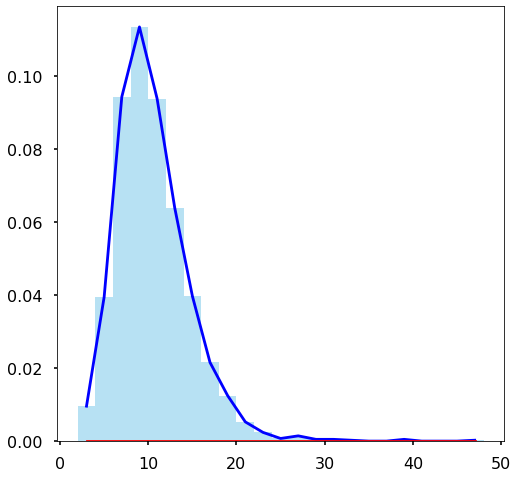

In [72]:
def double_gaussian( x, params ):
    (c1, mu1, sigma1, c2, mu2, sigma2) = params
    res =   c1 * np.exp( - (x - mu1)**2.0 / (2.0 * sigma1**2.0) ) \
          + c2 * np.exp( - (x - mu2)**2.0 / (2.0 * sigma2**2.0) )
    return res

def double_gaussian_fit( params ):
    fit = double_gaussian( x, params )
    return (fit - y_proc)

number_of_binding_events_per_site = np.asarray(number_of_binding_events_per_site)

mpl.style.use('seaborn-poster')
bins=range(int(number_of_binding_events_per_site.min()), int(number_of_binding_events_per_site.max()) + 2, 2)
fig = plt.figure(figsize=(8, 8))
fig.tight_layout()
 
entries, bins, patches = plt.hist(number_of_binding_events_per_site, bins=bins, density=True, label='', color = "skyblue", alpha = 0.6)

bin_middles = 0.5 * (bins[1:] + bins[:-1])

x = bin_middles
y = entries

y_proc = np.copy(y)
y_proc[y_proc < 5] = 0.0

fit = leastsq( double_gaussian_fit, [13.0,-13.0,1.0,60.0,3.0,1.0] )
plot( x, y, c='b' )
plot( x, double_gaussian( x, fit[0] ), c='r' )
 
#(mu1, sigma1) = norm.fit(number_of_binding_events_per_site)
 
#xax = np.linspace(0, max(number_of_binding_events_per_site)+1, 10000)
 
#best_fit_line1 = sp.stats.norm.pdf(xax, mu1, sigma1)
#plt.plot(xax, best_fit_line1, color = "darkorange", label = "Max (center) = "+str(int(np.round(mu1))))
     
#plt.legend()